In [5]:

import os
import sys
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchinfo import summary
import os
import sys
import matplotlib.pyplot as plt
import argparse
import shutil


In [6]:
import TRACK_POS, TRACK_SAL
import position_dataset

In [7]:
from Utils import cartesian_to_eulerian, eulerian_to_cartesian, get_max_sal_pos,load_dict_from_csv,all_metrics, store_list_as_csv, MetricOrthLoss, OrthDist
from data_utils import fan_nossdav_split, PositionDataset
from DatasetHelper import read_sampled_positions_for_trace, load_saliency, load_true_saliency, get_video_ids, get_user_ids, get_users_per_video, split_list_by_percentage, partition_in_train_and_test_without_any_intersection, partition_in_train_and_test_without_video_intersection, partition_in_train_and_test

In [10]:
if torch.cuda.is_available():
    device=torch.device("cuda")
    print("Using GPU")
dataset_name="Fan_NOSSDAV_17"
M_WINDOW=5
H_WINDOW=25
INIT_WINDOW=M_WINDOW
END_WINDOW=H_WINDOW
EPOCHS=500
NUM_TILES_WIDTH=480
NUM_TILES_HEIGHT=240
NUM_TILES_WIDTH_TRUE_SAL = 256
NUM_TILES_HEIGHT_TRUE_SAL = 256
RATE = 0.2
PERC_VIDEOS_TRAIN = 0.6
PERC_USERS_TRAIN = 0.6
BATCH_SIZE = 64
model_name='TRACK'
root_dataset_folder = os.path.join('D:', dataset_name)
EXP_NAME=f"_init_{INIT_WINDOW}_in_{M_WINDOW}_out_{H_WINDOW}_end_{END_WINDOW}"
SAMPLED_DATASET_FOLDER=os.path.join(root_dataset_folder,'sampled_dataset')
VIDEO_DATA_FOLDER=os.path.join(root_dataset_folder,'video_data')
SALIENCY_FOLDER = os.path.join(root_dataset_folder, 'extract_saliency/saliency')

Using GPU


In [11]:
videos = get_video_ids(VIDEO_DATA_FOLDER)
users = get_user_ids(VIDEO_DATA_FOLDER)
users_per_video = get_users_per_video(VIDEO_DATA_FOLDER)

In [13]:
users_per_video

{'coaster': array(['user21', 'user22', 'user23', 'user24', 'user25', 'user26',
        'user27', 'user28', 'user29', 'user30', 'user31', 'user32',
        'user33', 'user34', 'user35', 'user36', 'user37', 'user38',
        'user39', 'user40', 'user41', 'user42', 'user43', 'user44',
        'user45', 'user46', 'user47', 'user48', 'user49', 'user50'],
       dtype='<U6'),
 'coaster2': array(['user21', 'user22', 'user23', 'user24', 'user25', 'user26',
        'user27', 'user28', 'user29', 'user30', 'user31', 'user32',
        'user33', 'user34', 'user35', 'user36', 'user37', 'user38',
        'user39', 'user40', 'user41', 'user42', 'user43', 'user44',
        'user45', 'user46', 'user47', 'user48', 'user49', 'user50'],
       dtype='<U6'),
 'diving': array(['user21', 'user22', 'user23', 'user24', 'user25', 'user26',
        'user27', 'user28', 'user29', 'user30', 'user31', 'user32',
        'user33', 'user34', 'user35', 'user36', 'user37', 'user38',
        'user39', 'user40', 'user41', '

In [3]:
from sklearn.model_selection import train_test_split
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

In [14]:
drive_dir='D:/'
datasets=[#'MM_18',
          'Fan_NOSSDAV_17',
          'CVPR18',
          'PAMI18',
          'MMSys18',
          'Jin_22']

In [22]:
drive_dir='D:/'
datasets=[#'MM_18',
          'Fan_NOSSDAV_17',
          'CVPR18',
          'PAMI18',
          'MMSys18',
          'Jin_22']
for dataset in datasets:
    dataset_dir=os.path.join(drive_dir,dataset)
    video_data_path=os.path.join(dataset_dir,'video_data')
    vid_img_path=os.path.join(dataset_dir,'5fps_Video_Images')
    videos=os.listdir(video_data_path)
    for video in videos:
        video_folder=os.path.join(vid_img_path,video)
        if os.path.isdir(video_folder):
            si_file=os.path.join(video_folder,'video_SI.npy')
            ti_file=os.path.join(video_folder,'video_TI.npy')
            
            # Define the destination paths in the video_data directory
            dest_si_file = os.path.join(video_data_path, video, f'{video}_SI.npy')
            dest_ti_file = os.path.join(video_data_path, video, f'{video}_TI.npy')
            if os.path.isfile(si_file):
                shutil.move(si_file, dest_si_file)
                #print(f"Moved and renamed {si_file} to {dest_si_file}")
                
            # Move and rename the TI file if it exists
            if os.path.isfile(ti_file):
                shutil.move(ti_file, dest_ti_file)
                #print(f"Moved and renamed {ti_file} to {dest_ti_file}")
    print(f"Moved files for {dataset}")

Moved files for Fan_NOSSDAV_17
Moved files for CVPR18
Moved files for PAMI18
Moved files for MMSys18
Moved files for Jin_22


In [22]:
dataset_dir='D:/Jin_22'


In [35]:
def split_data(dataset_dir='D:/Jin_22',bins=2):
    data_dir=os.path.join(dataset_dir,'video_data')
    video_files=os.path.join(dataset_dir,'5fps_Video_Images')
    videos=os.listdir(data_dir)
    AE={}
    SI={}
    TI={}
    CE={}
    for video in videos:
        vid_path=os.path.join(data_dir,video)
        siti_path=os.path.join(video_files,video)
        AE[video]=np.load(os.path.join(vid_path,f'{video}_AEs.npy'))
        AE[video]=np.mean(AE[video])
        CE[video]=np.load(os.path.join(vid_path,f'{video}_content_entropy.npy'))
        CE[video]=np.mean(CE[video])
        SI[video]=np.load(os.path.join(siti_path,'video_SI.npy'))
        SI[video]=np.mean(SI[video])
        TI[video]=np.load(os.path.join(siti_path,'video_TI.npy'))
        TI[video]=np.mean(TI[video])
    ae_bins = pd.qcut(list(AE.values()), q=bins, labels=False)
    ce_bins = pd.qcut(list(CE.values()), q=bins, labels=False)
    si_bins = pd.qcut(list(SI.values()), q=bins, labels=False)
    ti_bins = pd.qcut(list(TI.values()), q=bins, labels=False)
    strat_keys = [f"{ae}_{ce}" for ae, ce in zip(ae_bins, ce_bins)]
    train_videos, test_videos = train_test_split(videos, test_size=0.2, stratify=strat_keys)
    # Separate the metrics into train and test sets
    train_AE = [AE[video] for video in train_videos]
    train_CE = [CE[video] for video in train_videos]

    test_AE = [AE[video] for video in test_videos]
    test_CE = [CE[video] for video in test_videos]
    # Step 4: Plot the metrics

    plt.figure(figsize=(12, 6))

    # Plot AE vs CE
    plt.scatter(train_AE, train_CE, color='blue', label='Train')
    plt.scatter(test_AE, test_CE, color='red', label='Test')
    plt.xlabel('AE')
    plt.ylabel('CE')
    plt.title('AE vs CE')
    plt.legend()

    plt.show()
    return train_videos,test_videos

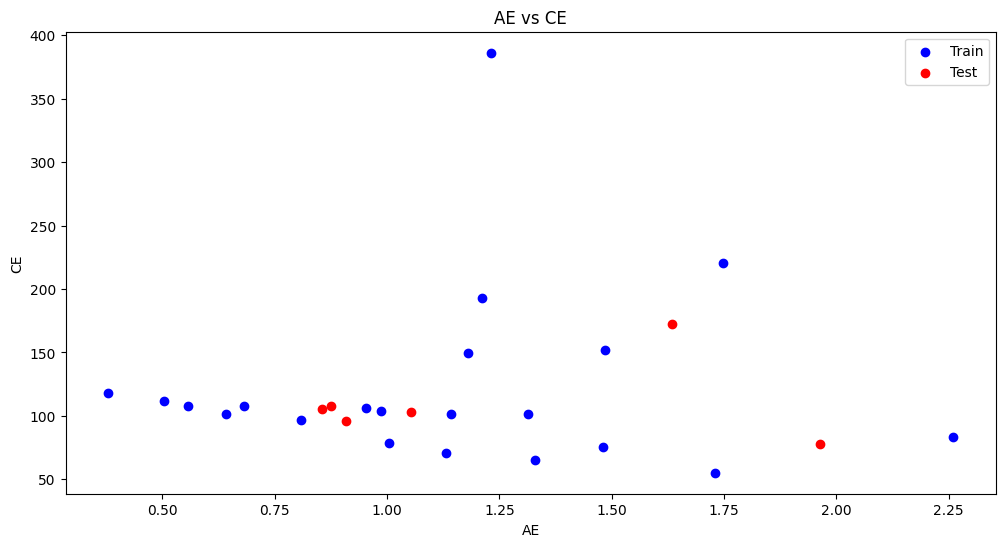

In [39]:
train,test=split_data()

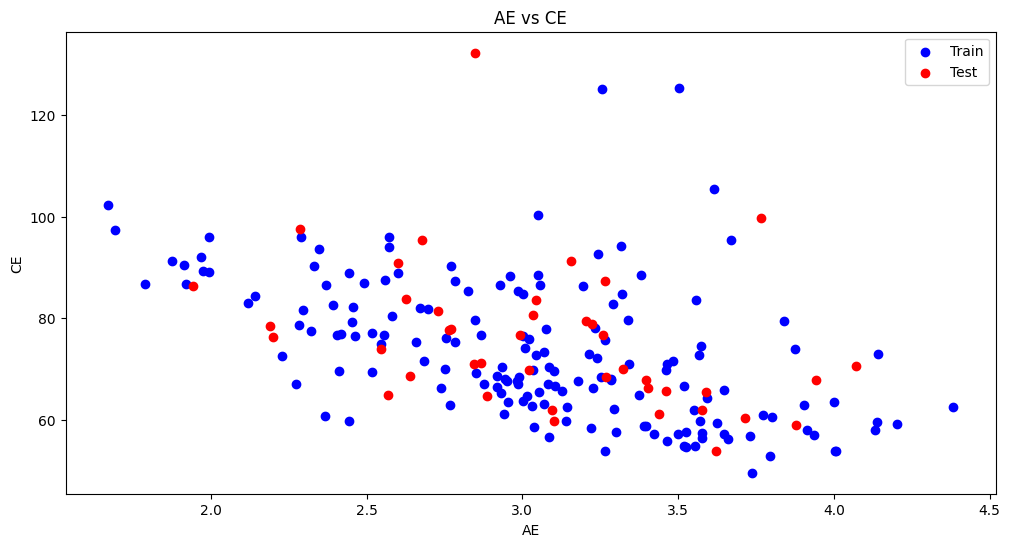

In [40]:
dataset_dir='D:/CVPR18'
train,test=split_data(dataset_dir)

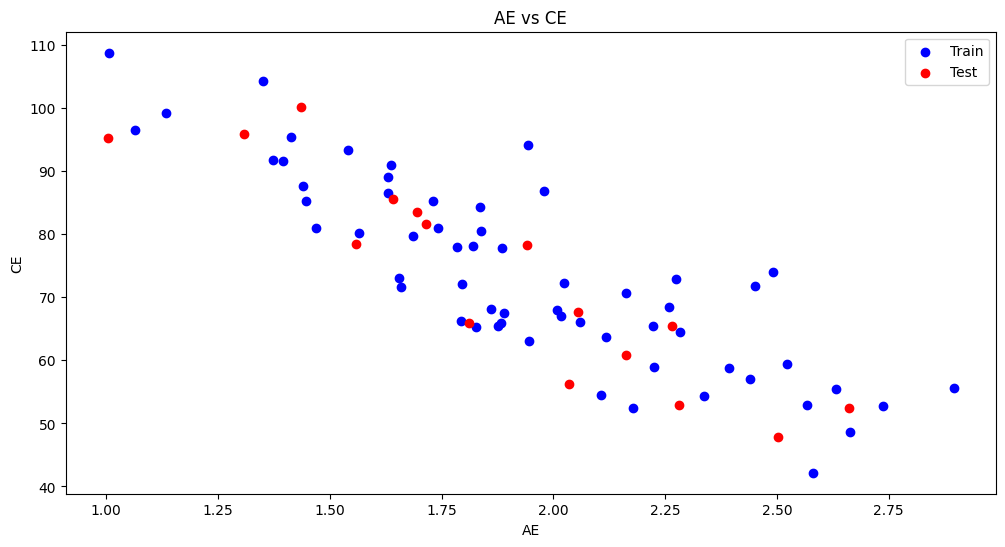

In [41]:
dataset_dir='D:/PAMI18'
train,test=split_data(dataset_dir)